### This notebook uses the Kaggle sarcastic news dataset and attempts to classify the news headlines provided in the dataset into the "normal" and "sarcastic" categories using deep learning models such as Keras sequential neural network and BERT for sequence classification from the Huggingface library.

Authors: 
- Sachin Peruri (sachin.peruri@gmail.com)
- Keyuri Raodeo (keyuri.raodeo@gmail.com)


In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
pip install transformers

In [ ]:
# Import libraries

import json
import pandas as pd
import pickle

from sklearn.model_selection import train_test_split

from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import InputExample, InputFeatures
import tensorflow as tf

from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.layers import Input
from keras.models import Model

from sklearn.model_selection import cross_val_score

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.model_selection import cross_val_score

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
import tensorflow_hub as hub

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices("GPU") else "NOT AVAILABLE")

Version:  2.6.0
Eager mode:  True
Hub version:  0.12.0
GPU is available


In [ ]:
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
def parse_data(file):
    for l in open(file,'r'):
        yield json.loads(l)

### Loading in the dataset

In [ ]:
# Parse and convert the data into a dataframe

data_v2 = list(parse_data("/gdrive/MyDrive/Sarcastic_news/Sarcasm_Headlines_Dataset_v2.json"))
df = pd.DataFrame.from_dict(data_v2)
df.sample(5)

,is_sarcastic,headline,article_link
18005,0,why this aborted airplane landing only looks l...,https://www.huffingtonpost.com/entry/plane-lan...
12730,0,pour it up! rihanna celebrates grammy win with...,https://www.huffingtonpost.com/entry/rihanna-g...
20024,1,humble ascetic declines in-flight beverage ser...,https://local.theonion.com/humble-ascetic-decl...
22685,1,romney frantically figuring out how tax plan c...,https://politics.theonion.com/romney-frantical...
16953,1,"'there are no good options in syria,' sighs ma...",https://www.theonion.com/there-are-no-good-opt...


In [ ]:
y = df["is_sarcastic"]

### Splitting into train and test data

In [ ]:
# Split data into train and test
X_train,X_test,y_train,y_test=train_test_split(df["headline"],df["is_sarcastic"],test_size=0.2,random_state=0)

In [ ]:
X_train.head()

11855    cdc warns once-eradicated jitterbug spreading ...
13986                30-year-old factors in birthday money
21529    amish woman knew she had quilt sale the moment...
4787                       playing monopoly with our lives
242      realistic day planner only includes first coup...
Name: headline, dtype: object

### Trying out a Keras binary classifier using NNLM 50D embeddings from Tensorflow-Hub.


In [ ]:
embedding = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(embedding, input_shape=[], 
                           dtype=tf.string, trainable=True)

# Input data as embeddings directly
embedded_x_train = hub_layer(X_train)

embedded_x_train = np.array(embedded_x_train)

embedded_x_test = hub_layer(X_test)
embedded_x_test = np.array(embedded_x_test)

INFO:absl:Using /tmp/tfhub_modules to cache modules.
INFO:absl:Downloading TF-Hub Module 'https://tfhub.dev/google/nnlm-en-dim50/2'.
INFO:absl:Downloaded https://tfhub.dev/google/nnlm-en-dim50/2, Total size: 191.83MB
INFO:absl:Downloaded TF-Hub Module 'https://tfhub.dev/google/nnlm-en-dim50/2'.


In [ ]:
len(X_train)

22895

In [ ]:
len(embedded_x_train)

22895

### Defining the Keras early stopping callback based on loss

In [ ]:
# Define Model

tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

# Defining Early stopping to stop training if validation accuracy does not improve within five epochs
callback = tf.keras.callbacks.EarlyStopping(
    monitor="loss",
    patience=5,
    verbose=1,
    restore_best_weights=True,
)

### Creating and adding Dense layers to the Keras model

In [ ]:
# Create model
model = Sequential()
model.add(Dense(50, input_dim=50, activation='relu'))
model.add(Dense(25, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

### Training the model using embedded train vectors and y_train

In [ ]:
train_history = model.fit(embedded_x_train, y_train, epochs=30, batch_size=16, callbacks = [callback])

Epoch 1/30
1431/1431 [==============================] - 8s 4ms/step - loss: 0.5340 - accuracy: 0.7324
Epoch 2/30
1431/1431 [==============================] - 5s 4ms/step - loss: 0.4875 - accuracy: 0.7610
Epoch 3/30
1431/1431 [==============================] - 5s 4ms/step - loss: 0.4722 - accuracy: 0.7732
Epoch 4/30
1431/1431 [==============================] - 5s 4ms/step - loss: 0.4614 - accuracy: 0.7777
Epoch 5/30
1431/1431 [==============================] - 5s 4ms/step - loss: 0.4532 - accuracy: 0.7839
Epoch 6/30
1431/1431 [==============================] - 5s 4ms/step - loss: 0.4463 - accuracy: 0.7874
Epoch 7/30
1431/1431 [==============================] - 5s 4ms/step - loss: 0.4400 - accuracy: 0.7901
Epoch 8/30
1431/1431 [==============================] - 5s 4ms/step - loss: 0.4351 - accuracy: 0.7964
Epoch 9/30
1431/1431 [==============================] - 5s 4ms/step - loss: 0.4309 - accuracy: 0.7981
Epoch 10/30
1431/1431 [==============================] - 5s 4ms/step - loss: 0.426

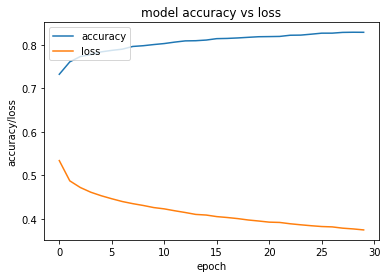

In [ ]:
# Summarize history for accuracy
plt.plot(train_history.history['accuracy'])
plt.plot(train_history.history['loss'])
plt.title('model accuracy vs loss')
plt.ylabel('accuracy/loss')
plt.xlabel('epoch')
plt.legend(['accuracy', 'loss'], loc='upper left')
plt.show()

### Looks like the model was was close to converging, however to avoid overfitting, model training was stopped at 30 epochs.

### Final loss was **0.3747** and accuracy was recorded to be **0.8289**

In [ ]:
y_pred = model.predict(embedded_x_test)
y_pred_1d = y_pred.ravel()

In [ ]:
y_pred_1d.shape

(5724,)

### Cleaning up the output and classifying into 0 or 1 based on 0.5 as the threshold.

In [ ]:
y_pred_cleaned = pd.Series(y_pred_1d).apply(lambda x: 0 if x < 0.5 else 1)

In [ ]:
metrics.confusion_matrix(y_test, y_pred_cleaned)

array([[2366,  664],
       [ 692, 2002]])

In [ ]:
target_names = ['normal', 'sarcastic']
print(classification_report(y_test, y_pred_cleaned, target_names=target_names))

              precision    recall  f1-score   support

      normal       0.77      0.78      0.78      3030
   sarcastic       0.75      0.74      0.75      2694

    accuracy                           0.76      5724
   macro avg       0.76      0.76      0.76      5724
weighted avg       0.76      0.76      0.76      5724



### The precision and recall on the training set was found to be 0.76, and F1-score was found to be 0.76 as well. This model seems to perform about as well as the best ML model found in the previous notebook, which was the Light Gradient Boosting Model or LGBM.

In [ ]:
y_pred_train = model.predict(embedded_x_train)
y_pred_train_1d = y_pred_train.ravel()
y_pred_train_cleaned = pd.Series(y_pred_train_1d).apply(lambda x: 0 if x < 0.5 else 1)

In [ ]:
metrics.confusion_matrix(y_train, y_pred_train_cleaned)

array([[10215,  1740],
       [ 1944,  8996]])

In [ ]:
target_names = ['normal', 'sarcastic']
print(classification_report(y_train, y_pred_train_cleaned, target_names=target_names))

              precision    recall  f1-score   support

      normal       0.84      0.85      0.85     11955
   sarcastic       0.84      0.82      0.83     10940

    accuracy                           0.84     22895
   macro avg       0.84      0.84      0.84     22895
weighted avg       0.84      0.84      0.84     22895



### The model performs slightly better on the training set as expected. The metrics even point to a slight bit of overfitting. 

### Best metrics on the train dataset were precision, recall and F1-score of 0.84 compared to 0.76 on the test dataset.

## Trying out the BERT model now from the Transformers library

### Reference: https://towardsdatascience.com/sentiment-analysis-in-10-minutes-with-bert-and-hugging-face-294e8a04b671

### Initializing the model

In [ ]:
model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/511M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

In [ ]:
model.summary()

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (TFBertMainLayer)       multiple                  109482240 
_________________________________________________________________
dropout_37 (Dropout)         multiple                  0         
_________________________________________________________________
classifier (Dense)           multiple                  1538      
Total params: 109,483,778
Trainable params: 109,483,778
Non-trainable params: 0
_________________________________________________________________


In [ ]:
X_train.head()

11855    cdc warns once-eradicated jitterbug spreading ...
13986                30-year-old factors in birthday money
21529    amish woman knew she had quilt sale the moment...
4787                       playing monopoly with our lives
242      realistic day planner only includes first coup...
Name: headline, dtype: object

In [ ]:
# Split data into train and test

train = pd.DataFrame.from_records(
    {
        "DATA_COLUMN" : X_train,
        "LABEL_COLUMN" : y_train
    }
)

test = pd.DataFrame.from_records(
    {
        "DATA_COLUMN" : X_test,
        "LABEL_COLUMN" : y_test
    }
)

### We define custom functions to convert our vanilla pandas dataframe dataset into a tensorflow dataset to use with BERT

In [ ]:
def convert_data_to_examples(train, test, DATA_COLUMN, LABEL_COLUMN): 
  train_InputExamples = train.apply(lambda x: InputExample(guid=None, 
                                                          text_a = x[DATA_COLUMN], 
                                                          text_b = None,
                                                          label = x[LABEL_COLUMN]), axis = 1)

  validation_InputExamples = test.apply(lambda x: InputExample(guid=None, 
                                                          text_a = x[DATA_COLUMN], 
                                                          text_b = None,
                                                          label = x[LABEL_COLUMN]), axis = 1)
  
  return train_InputExamples, validation_InputExamples
  
def convert_examples_to_tf_dataset(examples, tokenizer, max_length=128):
    features = [] # will hold InputFeatures to be converted later

    for e in examples:
        input_dict = tokenizer.encode_plus(
            e.text_a,
            add_special_tokens=True,
            max_length=max_length, # truncates if len(s) > max_length
            return_token_type_ids=True,
            return_attention_mask=True,
            pad_to_max_length=True, # pads to the right by default 
            truncation=True
        )

        input_ids, token_type_ids, attention_mask = (input_dict["input_ids"],
            input_dict["token_type_ids"], input_dict['attention_mask'])

        features.append(
            InputFeatures(
                input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, label=e.label
            )
        )

    def gen():
        for f in features:
            yield (
                {
                    "input_ids": f.input_ids,
                    "attention_mask": f.attention_mask,
                    "token_type_ids": f.token_type_ids,
                },
                f.label,
            )

    return tf.data.Dataset.from_generator(
        gen,
        ({"input_ids": tf.int32, "attention_mask": tf.int32, "token_type_ids": tf.int32}, tf.int64),
        (
            {
                "input_ids": tf.TensorShape([None]),
                "attention_mask": tf.TensorShape([None]),
                "token_type_ids": tf.TensorShape([None]),
            },
            tf.TensorShape([]),
        ),
    )


DATA_COLUMN = 'DATA_COLUMN'
LABEL_COLUMN = 'LABEL_COLUMN'

In [ ]:
train_InputExamples, validation_InputExamples = convert_data_to_examples(train, test, DATA_COLUMN, LABEL_COLUMN)

train_data = convert_examples_to_tf_dataset(list(train_InputExamples), tokenizer)
train_data = train_data.shuffle(100).batch(32)

validation_data = convert_examples_to_tf_dataset(list(validation_InputExamples), tokenizer)
validation_data = validation_data.batch(32)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2217: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Looking at an example in the train data. BERT needs the vectorized input, along with the attention mask, token_type_ids (not used here) as well as the y_labels in batches of 32. 

Max batch size depends on GPU VRAM size. Batch size greater than 32 did not seem to work.

In [ ]:
for x in train_data:
  print(x)
  break

({'input_ids': <tf.Tensor: shape=(32, 128), dtype=int32, numpy=
array([[  101,  3870,  6031, ...,     0,     0,     0],
       [  101,  6014, 14816, ...,     0,     0,     0],
       [  101,  2158,  5496, ...,     0,     0,     0],
       ...,
       [  101,  2047,  2381, ...,     0,     0,     0],
       [  101, 23222,  2402, ...,     0,     0,     0],
       [  101,  8398, 17472, ...,     0,     0,     0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(32, 128), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>, 'token_type_ids': <tf.Tensor: shape=(32, 128), dtype=int32, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)>

### Compiling and fitting the model on the train data

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08, clipnorm=1.0), 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy('accuracy')])

history = model.fit(train_data, epochs=1, validation_data=validation_data, verbose = 1)

716/716 [==============================] - 1143s 2s/step - loss: 0.0664 - accuracy: 0.9776 - val_loss: 0.1980 - val_accuracy: 0.9313


In [ ]:
history.history

{'accuracy': [0.9775933623313904],
 'loss': [0.06642692536115646],
 'val_accuracy': [0.9313417077064514],
 'val_loss': [0.1979941725730896]}

### Training accuracy was recorded to be **0.977** after just 1 epoch (close to overfitting), while the validation accuracy was recorded to be **0.931**

### We are already seeing much better performance compared to "traditional" ML models and even simple Keras neural networks by using BERT.

### Testing the model on manually written news headlines

In [ ]:
# Test model prediction on example news headlines
pred_sentences = ['Elon musk rides Doge coin to the moon',
                  'China may be using sea to hide its submarines',
                  'Miracle cure kills fifth patient',
                  'Apple becomes first trillion dollar company']


In [ ]:
tf_batch = tokenizer(pred_sentences, max_length=128, padding=True, truncation=True, return_tensors='tf')
tf_outputs = model(tf_batch)
tf_predictions = tf.nn.softmax(tf_outputs[0], axis=-1)
labels = ['Normal','Sarcastic']
label = tf.argmax(tf_predictions, axis=1)
label = label.numpy()
for i in range(len(pred_sentences)):
  print(pred_sentences[i], ":", labels[label[i]])

Elon musk rides Doge coin to the moon : Normal
China may be using sea to hide its submarines : Normal
Miracle cure kills fifth patient : Sarcastic
Apple becomes first trillion dollar company : Sarcastic


#### The model did not seem to accurately predict Normal/Sarcastic for manually written sentences as the tone and style may not have matched the training dataset.

In [ ]:
test[:5]

,DATA_COLUMN,LABEL_COLUMN
151,exasperated huckabee sanders reminds press cor...,1
17228,if only all tampon ads were this honest,0
4725,moviegoer manages to sneak candy past teenage ...,1
4258,noaa predicts we'll see more hurricanes this y...,0
12250,new lawn-care product makes neighbor's lawn le...,1


### Looking at individual output from random sentences in the test data

In [ ]:
pred_sentences = list(test[240:250]['DATA_COLUMN'])

In [ ]:
pred_sentences

['incredible waterspout spotted over iowa lake',
 'ex-wall street banker convicted of giving his father insider tips',
 'assessing our children to death',
 'not very good album takes a little while to get into',
 "vlogger shamed in walmart fitting room because she might 'stretch' clothes",
 'james fenimore cooper, famed american novelist, dies at 224',
 'tourist scams, part 3: what to know before you go',
 "report: just 2 more days and you can forget all of this, vanish into 'red dead redemption 2'",
 'the definitive international guide to tipping',
 "new ted cruz campaign ad features his kids begging for beto o'rourke to be their new dad"]

In [ ]:
tf_batch = tokenizer(pred_sentences, max_length=128, padding=True, truncation=True, return_tensors='tf')
tf_outputs = model(tf_batch)
tf_predictions = tf.nn.softmax(tf_outputs[0], axis=-1)
labels = ['Normal','Sarcastic']
label = tf.argmax(tf_predictions, axis=1)
label = label.numpy()
for i in range(len(pred_sentences)):
  print(pred_sentences[i], ":", labels[label[i]])

incredible waterspout spotted over iowa lake : Normal
ex-wall street banker convicted of giving his father insider tips : Normal
assessing our children to death : Normal
not very good album takes a little while to get into : Sarcastic
vlogger shamed in walmart fitting room because she might 'stretch' clothes : Normal
james fenimore cooper, famed american novelist, dies at 224 : Normal
tourist scams, part 3: what to know before you go : Normal
report: just 2 more days and you can forget all of this, vanish into 'red dead redemption 2' : Sarcastic
the definitive international guide to tipping : Normal
new ted cruz campaign ad features his kids begging for beto o'rourke to be their new dad : Sarcastic


In [ ]:
test[240:250]

,DATA_COLUMN,LABEL_COLUMN
9431,incredible waterspout spotted over iowa lake,0
2343,ex-wall street banker convicted of giving his ...,0
12603,assessing our children to death,0
18752,not very good album takes a little while to ge...,1
21349,vlogger shamed in walmart fitting room because...,0
14239,"james fenimore cooper, famed american novelist...",1
18714,"tourist scams, part 3: what to know before you go",0
20377,report: just 2 more days and you can forget al...,1
14460,the definitive international guide to tipping,0
12614,new ted cruz campaign ad features his kids beg...,1


#### The model seemed to perform well on the test dataset, predicting only 1 headline incorrectly. This goes to show the power of transformer based models such as BERT even with fine-tuning of just 1 epoch.

Overall, we looked at various ML models using the incredible PyCaret library, with and without using NMF to reduce the dimensionality of the dataset. Here are some of the learnings through this project-

- Reducing dimensionality of the dataset using Non-negative matrix factorization or NMF seemed to decrease the precision/F1-score metrics by * *5-6 percentage points** but sped up the model fitting by a lot. 

- Thus, NMF reduction can be used where performance and time spent matters most.

- Training using the full dataset took much longer but gave the highest **F1-score of 0.78** using the fine-tuned LGBM classifier.

- Moving to Deep learning methods, even simple sequential neural networks seemed to match or exceed the grid-searched and fine-tuned LGBM classifier. This shows the power of adding complexity to the model.

- By using BERT, validation accuracy was recorded to be **0.93 after only 1 epoch**, which again shows the power of BERT over simple neural networks.

- We can also see the potential for overfitting by using a powerful model such as BERT, as the training accuracy seemed to reach 0.977 after just 1 epoch of fine-tuning.